In [1]:
import torch
import open_clip
import whisper
from pathlib import Path
import cv2
from PIL import Image
from video import delay_ms, video_path, runVideo
from bisect import bisect_left
from tqdm import tqdm

c:\Users\abhay\anaconda3\envs\ursa25\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print("""
Hell \
o
""")


Hell  o



In [8]:
torch.cuda.is_available()

True

In [6]:
model = whisper.load_model("base")
transcript = model.transcribe(str(video_path), word_timestamps=True)

timestamp_list = []

for segment in transcript["segments"]:
    timestamp_list.append((segment["start"] + segment["end"]) / 2)
    print(f"[{segment["start"]:.2f}-{segment["end"]:.2f}]:", segment["text"])

c:\Users\abhay\anaconda3\envs\ursa25\Lib\site-packages\whisper\timing.py:42: UserWarning: Failed to launch Triton kernels, likely due to missing CUDA toolkit; falling back to a slower median kernel implementation...
  warnings.warn(
c:\Users\abhay\anaconda3\envs\ursa25\Lib\site-packages\whisper\timing.py:146: UserWarning: Failed to launch Triton kernels, likely due to missing CUDA toolkit; falling back to a slower DTW implementation...
  warnings.warn(
c:\Users\abhay\anaconda3\envs\ursa25\Lib\site-packages\whisper\timing.py:42: UserWarning: Failed to launch Triton kernels, likely due to missing CUDA toolkit; falling back to a slower median kernel implementation...
  warnings.warn(
c:\Users\abhay\anaconda3\envs\ursa25\Lib\site-packages\whisper\timing.py:146: UserWarning: Failed to launch Triton kernels, likely due to missing CUDA toolkit; falling back to a slower DTW implementation...
  warnings.warn(


[1.44-6.58]:  Hi there, I'm going to show you one of the most popular ways to tie a tie, using the
[6.58-14.70]:  Windsor knot. Also known as a double Windsor, or a full Windsor. Start with your
[14.70-18.68]:  collar up in the tie around your neck. If you right-hand it on the wide end in
[18.68-24.92]:  your right hand and the narrow end in your left hand. Now it's important to remember
[25.34-28.88]:  that the longer you make the wide end below the tie will hang when you finished.
[29.68-33.82]:  Basically you want to line up your tie like this. If you remember this you'll
[33.82-35.38]:  save yourself a lot of time later on.
[38.36-43.90]:  Now cross each end over, wide end over the top, and leave about this much on the narrow end.
[44.64-46.98]:  That's about four inches or ten centimeters.
[50.80-56.04]:  With your left hand take the wide end, thread it through the back of this opening from behind.
[56.84-59.08]:  Thread it all the way through like this.
[66.80-69.62]:  Now take t

In [7]:
def get_text_from_timestamp(timestamp):
    idx = min(bisect_left(timestamp_list, timestamp), len(timestamp_list) - 1)
    return transcript["segments"][idx]["text"]


In [8]:
print(get_text_from_timestamp(157))

 Gradually pulling the knot up, shaping it as you go until it's just how you want it to be.


In [9]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
tokenizer = open_clip.get_tokenizer('ViT-B-32')

with torch.no_grad():
    for i, frame in enumerate(runVideo(wait=False)):
        if i % 200 != 0:
            continue
        print("[", (delay_ms * i) / 1000, "]: ", sep="", end="")
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        image_input = preprocess(image).unsqueeze(0)
        image_features = model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text = get_text_from_timestamp(timestamp=delay_ms * i / 1000)
        text_tokens = tokenizer([text])
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (image_features @ text_features.T).squeeze(0)
        print(similarity, text)


c:\Users\abhay\anaconda3\envs\ursa25\Lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


[0.0]: tensor([0.2153])  Hi there, I'm going to show you one of the most popular ways to tie a tie, using the
[8.0]: tensor([0.3081])  Windsor knot. Also known as a double Windsor, or a full Windsor. Start with your
[16.0]: tensor([0.2730])  collar up in the tie around your neck. If you right-hand it on the wide end in
[24.0]: tensor([0.3045])  that the longer you make the wide end below the tie will hang when you finished.
[32.0]: tensor([0.2382])  save yourself a lot of time later on.
[40.0]: tensor([0.1931])  Now cross each end over, wide end over the top, and leave about this much on the narrow end.
[48.0]: tensor([0.2652])  With your left hand take the wide end, thread it through the back of this opening from behind.
[56.0]: tensor([0.2471])  Thread it all the way through like this.
[64.0]: tensor([0.2498])  Now take the wide end and with your left hand,
[72.0]: tensor([0.2340])  wrap it all the way around the back like this.
[80.0]: tensor([0.2673])  Take the wide end now in your

In [10]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [11]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")

In [12]:
counterfactual_list = []

for x in tqdm(transcript["segments"]):
    text = x["text"]
    print("Input:", text)
    summary_instruction = f"""
    Write a concise, natural phrase that captures the main action or event described in this text \
    (e.g., "person laughs", "car drives away"). 
    Avoid repetition or unnecessary words.
    Text: {text}
    """
    encoder_inputs = tokenizer(summary_instruction, return_tensors="pt", max_length=512, truncation=True)
    output = model.generate(
        input_ids=encoder_inputs["input_ids"], 
        attention_mask=encoder_inputs["attention_mask"],
        max_length=10
    )[0]
    output_summary_text = tokenizer.decode(output, skip_special_tokens=True)
    negated_instructions = f"""
    Convert the following phrase into its opposite meaning. Try change every word if possible.
    Negate it to completely mean the opposite idea. The new negated phrase must be as different from the original text.
    Examples: "rises" becomes "lowers", "death" becomes "life", "end" becomes "start", \
    "one" becomes "two", "up " becomes "down".
    Phrase: {output_summary_text}
    """
    encoder_inputs = tokenizer(negated_instructions, return_tensors="pt", max_length=512, truncation=True)
    output = model.generate(
        input_ids=encoder_inputs["input_ids"], 
        attention_mask=encoder_inputs["attention_mask"],
        max_length=10
    )[0]
    output_negated_text = tokenizer.decode(output, skip_special_tokens=True)
    print(f"Output: {output_summary_text} | {output_negated_text}\n")
    counterfactual_list.append([output_summary_text, output_negated_text])

  0%|          | 0/28 [00:00<?, ?it/s]

Input:  Hi there, I'm going to show you one of the most popular ways to tie a tie, using the


  4%|▎         | 1/28 [00:08<03:37,  8.06s/it]

Output: one of the most popular ways to tie  | one of the most unpopular ways to tie

Input:  Windsor knot. Also known as a double Windsor, or a full Windsor. Start with your


  7%|▋         | 2/28 [00:08<01:39,  3.85s/it]

Output: Windsor knot | Windsor knot

Input:  collar up in the tie around your neck. If you right-hand it on the wide end in


 11%|█         | 3/28 [00:10<01:13,  2.94s/it]

Output: collar up in the tie around your neck | collar down in the tie around your neck

Input:  your right hand and the narrow end in your left hand. Now it's important to remember


 14%|█▍        | 4/28 [00:12<00:58,  2.45s/it]

Output: the narrow end in your left hand. | the narrow end in your right hand.

Input:  that the longer you make the wide end below the tie will hang when you finished.


 18%|█▊        | 5/28 [00:14<00:49,  2.14s/it]

Output: that the longer you make the wide end below | that the shorter you make the wide end above

Input:  Basically you want to line up your tie like this. If you remember this you'll


 21%|██▏       | 6/28 [00:15<00:38,  1.77s/it]

Output: line up your tie | line up your shirt

Input:  save yourself a lot of time later on.


 25%|██▌       | 7/28 [00:16<00:36,  1.75s/it]

Output: save yourself a lot of time later on | save yourself a lot of time later on

Input:  Now cross each end over, wide end over the top, and leave about this much on the narrow end.


 29%|██▊       | 8/28 [00:18<00:32,  1.60s/it]

Output: cross each end over, wide end over the | wide end over the

Input:  That's about four inches or ten centimeters.


 32%|███▏      | 9/28 [00:19<00:30,  1.58s/it]

Output: That's about four inches or ten | That's about four inches or ten

Input:  With your left hand take the wide end, thread it through the back of this opening from behind.


 36%|███▌      | 10/28 [00:21<00:28,  1.58s/it]

Output: Thread the wide end through the back of the | Thread the narrow end through the back of the

Input:  Thread it all the way through like this.


 39%|███▉      | 11/28 [00:22<00:25,  1.48s/it]

Output: Thread it through the hole. | Thread it through the hole.

Input:  Now take the wide end and with your left hand,


 43%|████▎     | 12/28 [00:24<00:24,  1.51s/it]

Output: take the wide end and with your left hand | take the narrow end and with your right hand

Input:  wrap it all the way around the back like this.


 46%|████▋     | 13/28 [00:25<00:21,  1.42s/it]

Output: wrap it around the back. | wrap it around the back.

Input:  Switch hands. Notice here how the back of the tie is facing outward.


 50%|█████     | 14/28 [00:26<00:17,  1.27s/it]

Output: switch hands. | switch hands.

Input:  Take the wide end now in your right hand, thread it through the front of this opening,


 54%|█████▎    | 15/28 [00:27<00:17,  1.36s/it]

Output: thread the wide end through the front of this | thread the narrow end through the front of this

Input:  we're going through the front and down this time. Thread it through all the way down like this.


 57%|█████▋    | 16/28 [00:29<00:17,  1.43s/it]

Output: we're going through the front and down | we're going through the back and up

Input:  All right, hardest parts now done. The rest is easy. What you can see here is the inside of


 61%|██████    | 17/28 [00:30<00:14,  1.31s/it]

Output: the rest is easy | the rest is hard

Input:  your knot. Should look a bit like a triangle. Put your left index finger on the knot,


 64%|██████▍   | 18/28 [00:32<00:14,  1.40s/it]

Output: if you have a left hand, | if you have a right hand,

Input:  like this, and keep it there. With your other hand, wrap the wide end around the knot


 68%|██████▊   | 19/28 [00:33<00:13,  1.46s/it]

Output: wrap the wide end around the knot | wrap the narrow end around the knot

Input:  from right to left, and then grab it from behind. Keep your index finger where it is.


 71%|███████▏  | 20/28 [00:34<00:10,  1.33s/it]

Output: grab the ring | grab the ring

Input:  With your right hand, push the wide end through this opening again from the back,


 75%|███████▌  | 21/28 [00:36<00:09,  1.41s/it]

Output: push the wide end through the opening again from | push the narrow end through the opening again from

Input:  so we're coming up and through the back like this, threading it through the hole.


 79%|███████▊  | 22/28 [00:37<00:08,  1.48s/it]

Output: we're coming up and through the back | we're coming down and through the back

Input:  All right, here comes the punch line. Your index finger has created a little tunnel.


 82%|████████▏ | 23/28 [00:38<00:06,  1.30s/it]

Output: punch line | punch line is

Input:  What you need to do now is thread the tie down through the tunnel and pull it down.


 86%|████████▌ | 24/28 [00:40<00:05,  1.42s/it]

Output: thread the tie down through the tunnel. | thread the tie up through the tunnel.

Input:  The last step now is to adjust and tighten it, alternating between the long end and the short end.


 89%|████████▉ | 25/28 [00:42<00:04,  1.55s/it]

Output: the last step is to adjust and tighten | the first step is to adjust and loosen

Input:  Gradually pulling the knot up, shaping it as you go until it's just how you want it to be.


 93%|█████████▎| 26/28 [00:43<00:02,  1.40s/it]

Output: pull the knot up | pull the knot down

Input:  A sharp symmetrical triangular knot. Pull your collar down and bingo, the full winds are not.


 96%|█████████▋| 27/28 [00:44<00:01,  1.45s/it]

Output: pull your collar down and bingo, the full | pull your collar up and bingo, the full

Input:  Thank you for watching. I hope you found this helpful.


100%|██████████| 28/28 [00:46<00:00,  1.64s/it]

Output: thank you for watching | thank you for not watching



In [13]:
counterfactual_list_adjusted = [[x, y] if x != y else [x, "not " + x] for x, y in counterfactual_list]
counterfactual_list_adjusted

[['one of the most popular ways to tie ',
  'one of the most unpopular ways to tie'],
 ['Windsor knot', 'not Windsor knot'],
 ['collar up in the tie around your neck',
  'collar down in the tie around your neck'],
 ['the narrow end in your left hand.', 'the narrow end in your right hand.'],
 ['that the longer you make the wide end below',
  'that the shorter you make the wide end above'],
 ['line up your tie', 'line up your shirt'],
 ['save yourself a lot of time later on',
  'not save yourself a lot of time later on'],
 ['cross each end over, wide end over the', 'wide end over the'],
 ["That's about four inches or ten", "not That's about four inches or ten"],
 ['Thread the wide end through the back of the',
  'Thread the narrow end through the back of the'],
 ['Thread it through the hole.', 'not Thread it through the hole.'],
 ['take the wide end and with your left hand',
  'take the narrow end and with your right hand'],
 ['wrap it around the back.', 'not wrap it around the back.'],


In [14]:
def get_counterfactual_text_from_timestamp(timestamp):
    idx = min(bisect_left(timestamp_list, timestamp), len(timestamp_list) - 1)
    return counterfactual_list_adjusted[idx]

In [15]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
tokenizer = open_clip.get_tokenizer('ViT-B-32')

similarities = []

with torch.no_grad():
    for i, frame in enumerate(runVideo(wait=False)):
        if i % 100 != 0:
            continue
        print("[", (delay_ms * i) / 1000, "]: ", sep="", end="")
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        image_input = preprocess(image).unsqueeze(0)
        image_features = model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        texts = get_counterfactual_text_from_timestamp(timestamp=delay_ms * i / 1000)
        text_tokens = tokenizer(texts)
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (image_features @ text_features.T).squeeze(0)
        print(similarity, texts)
        similarities.append(similarity)

[0.0]: tensor([0.2134, 0.2218]) ['one of the most popular ways to tie ', 'one of the most unpopular ways to tie']
[4.0]: tensor([0.3184, 0.3028]) ['one of the most popular ways to tie ', 'one of the most unpopular ways to tie']
[8.0]: tensor([0.3165, 0.3038]) ['Windsor knot', 'not Windsor knot']
[12.0]: tensor([0.2919, 0.2986]) ['collar up in the tie around your neck', 'collar down in the tie around your neck']
[16.0]: tensor([0.2815, 0.2888]) ['collar up in the tie around your neck', 'collar down in the tie around your neck']
[20.0]: tensor([0.2315, 0.2333]) ['the narrow end in your left hand.', 'the narrow end in your right hand.']
[24.0]: tensor([0.2478, 0.2494]) ['that the longer you make the wide end below', 'that the shorter you make the wide end above']
[28.0]: tensor([0.2745, 0.2696]) ['line up your tie', 'line up your shirt']
[32.0]: tensor([0.2423, 0.2392]) ['save yourself a lot of time later on', 'not save yourself a lot of time later on']
[36.0]: tensor([0.2384, 0.2249]) ['

In [16]:
import numpy as np
import matplotlib.pyplot as plt

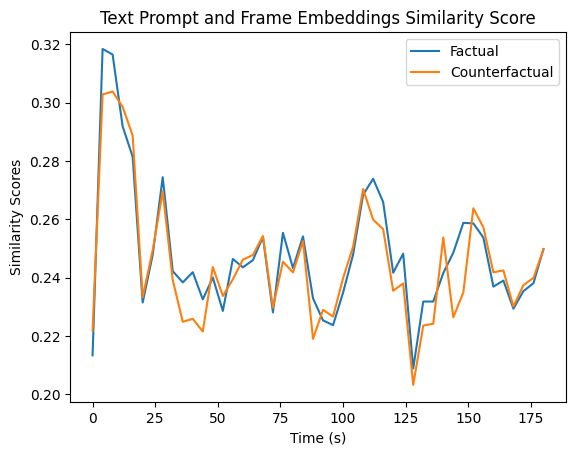

In [35]:
x_values = np.arange(len(similarities)) * delay_ms / 1000 * 100
y_values = np.array(similarities)

#print(y_values[:, 0] / y_values[:, 1])

y_values = np.column_stack([y_values, y_values[:, 0] / y_values[:, 1]])

plt.plot(x_values, y_values[:, 0], linestyle="-", label="Factual")
plt.plot(x_values, y_values[:, 1], linestyle="-", label="Counterfactual")
plt.xlabel("Time (s)")
plt.ylabel("Similarity Scores")
plt.title("Text Prompt and Frame Embeddings Similarity Score")

plt.legend()

plt.show()

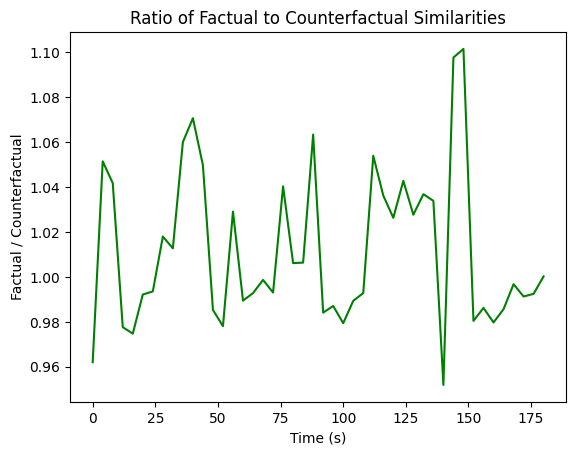

In [33]:
plt.plot(x_values, y_values[:, 2], linestyle="-", label="Factual / Counterfactual", color="g")

plt.xlabel("Time (s)")
plt.ylabel("Factual / Counterfactual")
plt.title("Ratio of Factual to Counterfactual Similarities")

plt.show()